# Estimation of parameters

In this tutorial, we show an detailed example of how you can use a pre-trained neural network to estimate biomarkers from input signals. We use the network that we trained to obtain the results presented in our paper. 

In [1]:
import sys
depth = '../'
for i in range(5):
    sys.path.append(depth)
    depth += '../'
import os
from os.path import isfile, join
import importlib
import numpy as np
import torch
import scipy as sc
from scipy.io import loadmat
import pickle
import MRF
from MRF.Training_parameters import *
from MRF.BaseModel import *
from MRF.Projection import *
from MRF.models import *
from MRF.Offline import Network, Data_class, Performances
import matplotlib.pyplot as plt

root = '../../../../'

## 1) Description of the processed signals

In order to preserve anonymity of MRI volunteers, we do not provide the data corresponding to the reconstructed images obtained from a full scan. We will be focused on a specific slice and show how we can use our pre-trained networks to get results. The data corresponding to this specific slice can be found in the folder `paper_data`.

In [2]:
test_slice = sc.io.loadmat(root+'paper_data/invivo_test_slice.mat')['x']

## 2) Parameters estimation

We use our pre-trained neural network to estimate the three parameters $m_0^s$, $T_1^f$ and $T_2^f$.

We define a directory to save results.

In [3]:
save_root='/NN_recon/'
if not os.path.exists(save_root):
    os.makedirs(save_root)

We give the list of the names of the trained networks that we want to use to process data. 

In [4]:
names = [ 'CRB-paper']

We give the list of paths where we saved the input signals that we want to process using the above mentioned pre-trained networks.

In [5]:
data_files = ['paper_data/invivo_test_slice.mat']

In [6]:
with open(root+'settings_files_offline/settings_'+name+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        print(settings)

NameError: name 'name' is not defined

We compute the estimate of the parameters and we save the results.

In [7]:
t_1 = time.time()
for name, data_file in zip(names, data_files):
    filepath = os.path.join(root, data_file)
    with open(root+'settings_files_offline/settings_'+name+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        
        ##################
        # Neural Network Architecture #
        ##################
        model = importlib.import_module('MRF.models.' + settings['name_model'])
        
        settings['namepca'] = root+'/paper_data/basis_for_compress.mat'

        ##################
        # Loading the pre-trained network #
        ##################
        net = torch.load(join(root,'save_networks_offline/network_'+settings['name_model']),map_location='cpu')
        training_parameters = Training_parameters(settings['batch_size'], 1, settings['nb_epochs'], settings['params'], settings['normalization'], settings['complex'])
        projection = Projection(settings['start_by_projection'], settings['dimension_projection'], settings['initialization'], settings['normalization'], settings['namepca'], settings['complex'])
        data_class = Data_class(training_parameters, settings['noise_type'], settings['noise_level'],
                                           settings['minPD'], settings['maxPD'], settings['nb_files'], settings['path_files'])
        validation_settings = {'validation': settings['validation'],'small_validation_size': settings['small_validation_size'], 'validation_size': settings['validation_size']}
        netw = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cpu')
        try:
            netw.load_state_dict(net['NN'])
        except:
            projection = Projection(settings['start_by_projection'], settings['dimension_projection'], 'Fixlayer', settings['normalization'], settings['namepca'], settings['complex'], ghost=True)
            netw = model.model(projection=projection,nb_params=len(settings['params']))
            netw.load_state_dict(net['NN'])
        netw.eval()

        ##################
        # Importing data #
        ##################
        import h5py
        import numpy as np
        try:
            from scipy.io import loadmat
            arrays = loadmat(filepath)
            fingers = arrays['x']
            fingers = fingers.T
        except:
            arrays = {}
            f = h5py.File(filepath, 'r')
            for k, v in f.items():
                 arrays[k] = np.array(v)
            fingers = arrays['x']
        t_2 = time.time()
        
        ##################
        # Preparing the neural network by removing the potential first projection layer #
        ##################
        projection.initialization = 'Fixlayer'
        netwproj = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cpu')
        dico = net['NN']
        try:
            if net['complex']:
                del dico['fc1_real.weight']
                del dico['fc1_imag.weight']
            else:
                del dico['fc1.weight']
        except:
            pass
        mrfshape = fingers.shape
        netwproj.load_state_dict(dico, strict=False)
        netwproj.eval()
        
        ##################
        # Estimating the biophysical parameters #
        ##################
        with torch.no_grad():
            if len(mrfshape)<=3:
                mrfshape = np.hstack((mrfshape,[1]))
            fings = fingers.reshape((-1, mrfshape[1],mrfshape[2] * mrfshape[3]))
            sequence_to_stack = []
            for i in range(mrfshape[1]):
                fings_tmp = fings[:,i,:].T
                params_tmp = netwproj(torch.tensor(fings_tmp, dtype=torch.float))
                params_tmp = np.array(params_tmp)
                for ii, para in enumerate(settings['params']):
                    if settings['loss'][para] == 'MSE-Log':
                        params_tmp[:, ii] = 10 ** params_tmp[:, ii]
                params_tmp = params_tmp.reshape((mrfshape[2],mrfshape[3],len(settings['params'])))
                sequence_to_stack.append(params_tmp)
            params = np.stack(sequence_to_stack,axis=0)
            
        ##################
        # Saving results and displaying processing time #
        ##################
        processing_time = time.time() - t_2
        params = np.moveaxis(params, [0, 2], [2, 0])
        total_time = time.time() - t_1
        print(os.path.join(save_root, 'qM_'+data_file[2:-4]+ '_'+name+'.mat'))
        print('done results')
        print('processing_time')
        print(processing_time)
        print('total_time')
        print(total_time)

/NN_recon/qM_per_data/invivo_test_slice_CRB-paper.mat
done results
processing_time
3.6539628505706787
total_time
3.903989315032959


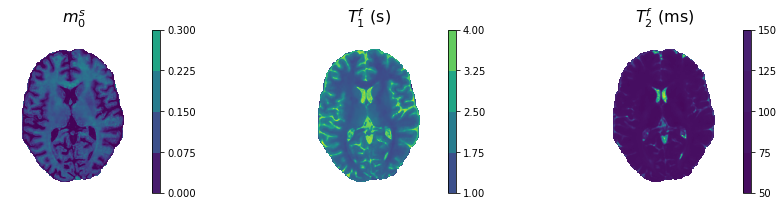

In [8]:
fig, ax = plt.subplots(len(net['params'])//3,3, figsize=(15,3))

ranges = [[0,0.3],[1,4],[50,150]]
scaling = [1,1,1e3]
units = ['',' (s)',' (ms)']
for i, ind in enumerate(net['params']):
    shw = ax[i].imshow(scaling[i]*params[0,:,:,i].T)
    ax[i].set_title(paramtolatexname[ind]+units[i], size=16)
    plt.colorbar(shw, ax=ax[i], boundaries=np.linspace(ranges[i][0],ranges[i][1],5))
    ax[i].axis('off')
plt.show()